In [1]:
import cc3d
import numpy as np
import pandas as pd
from miccai_dice import dice
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from miccai_dice import get_LesionWiseResults, dice
from proposed_dice import proposed_metric

def find_overlapping_components(prediction_cc, gt_cc):
    overlapping_components = {}
    
    # Iterate through each pixel in the prediction connected component array
    for i in range(prediction_cc.shape[0]):
        for j in range(prediction_cc.shape[1]):
            prediction_component = prediction_cc[i, j]
            gt_component = gt_cc[i, j]
            
            # Check if the prediction component overlaps with any ground truth component
            if prediction_component != 0 and gt_component != 0:
                # Store the overlapping components in a dictionary
                if prediction_component not in overlapping_components:
                    overlapping_components[prediction_component] = set()
                overlapping_components[prediction_component].add(gt_component)
    
    # Filter out prediction components overlapping with only one ground truth component
    overlapping_components = {k: v for k, v in overlapping_components.items() if len(v) > 1}

    return overlapping_components

def collect_legacy_metrics(pred_label_cc, gt_label_cc):

    legacy_metrics = []
    tp = []
    fp = []

    for gtcomp in range(1, np.max(gt_label_cc) + 1):

        gt_tmp = np.zeros_like(gt_label_cc)
        gt_tmp[gt_label_cc == gtcomp] = 1

        intersecting_cc = np.unique(pred_label_cc * gt_tmp)
        intersecting_cc = intersecting_cc[intersecting_cc != 0]
        for cc in intersecting_cc:
            tp.append(cc)

        if len(intersecting_cc) == 0:
            legacy_metrics.append({'GT'  : gtcomp,
                                   'Pred': 0,
                                   'Dice': 0})
        
        else:
            for predcomp in intersecting_cc:
                pred_tmp = np.zeros_like(pred_label_cc)
                pred_tmp[pred_label_cc == predcomp] = 1

                legacy_metrics.append({'GT'  : gtcomp,
                                       'Pred': predcomp,
                                       'Dice': dice(pred_tmp, gt_tmp)})
    
    fp = np.unique(pred_label_cc[np.isin(pred_label_cc,tp+[0],invert=True)])

    return legacy_metrics, fp    

def collect_overlap_metrics(pred_label_cc, gt_label_cc, overlapping_components):

    overlap_metrics = []

    for pred_components, gt_components in overlapping_components.items():
        gtcomps = list(gt_components)

        pred_label_cc_tmp = pred_label_cc.copy()
        gt_label_cc_tmp = gt_label_cc.copy()

        pred_cc_tmp = (pred_label_cc_tmp == pred_components).astype(int)
        gt_cc_tmp = np.array([[1 if (x > 0 and x in gtcomps) else 0 for x in sublist] for sublist in gt_label_cc_tmp])    

        overlap_metrics.append({'GT'  : gtcomps,
                                'Pred': pred_components,
                                'Dice': dice(pred_cc_tmp, gt_cc_tmp)})

    return overlap_metrics

def collect_metrics(pred_label_cc, gt_label_cc, overlapping_components):

    legacy_metrics, fp = collect_legacy_metrics(pred_label_cc, gt_label_cc)
    legacy_metrics = pd.DataFrame(legacy_metrics)
    overlap_metrics = collect_overlap_metrics(pred_label_cc, gt_label_cc, overlapping_components)
    overlap_metrics = pd.DataFrame(overlap_metrics)

    final_metrics_df = pd.concat([legacy_metrics, overlap_metrics], ignore_index=True)

    pred_list = []
    pred_int = []

    for index, row in final_metrics_df.iterrows():
        if isinstance(row['GT'], list):
            pred_list.append(row['Pred'])
        if isinstance(row['GT'], int):
            pred_int.append(row['Pred'])

    common_elements = set(pred_list).intersection(set(pred_int))

    for index, row in final_metrics_df.iterrows():
        if row['Pred'] in common_elements and isinstance(row['GT'], int):
            final_metrics_df.drop(index, inplace=True)
    
    return final_metrics_df, fp

def lesion_wise_metric(df, fp):

    dice_scores = df['Dice'].to_list()

    lesion_wise_dice = np.sum(dice_scores) / (len(dice_scores) + len(fp))

    lesion_wise_dice_fp = np.sum(dice_scores) / len(dice_scores)

    return lesion_wise_dice, lesion_wise_dice_fp

def proposed_metric(pred, gt):

    gt_label_cc = cc3d.connected_components(gt)
    pred_label_cc = cc3d.connected_components(pred)

    overlapping_components = find_overlapping_components(pred_label_cc, gt_label_cc)

    metrics, fp = collect_metrics(pred_label_cc, gt_label_cc, overlapping_components)

    return lesion_wise_metric(metrics, fp)

#Psuedo Algorithm
#1. Compute connected components for prediction and ground truth
#2. Calculate dice like miccai_dice
#2. Find overlapping components
#3. Isolate overlapping components
#4. Calculate lesion wise dice again
#5. Choose only the results of only those GTs which are isolated and not common with any other GTs


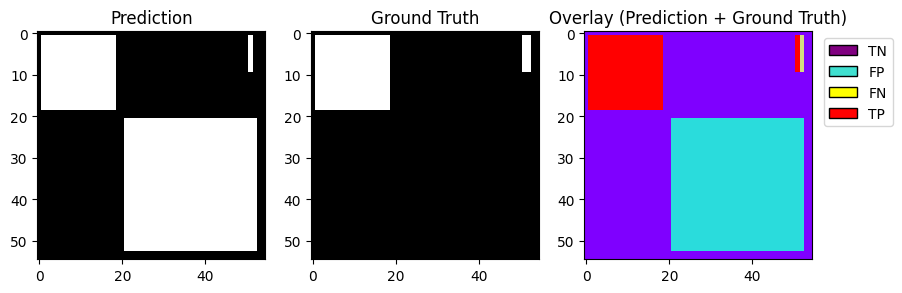

Legacy Dice           : 0.39199529134785166
Accounting for Lone FP: 0.33107710417892866
Normal with accounting: 0.22071806945261913
Miccai Dice           : 0.5555555555555555
Proposed Dice         : 0.5555555555555555


In [2]:
pred = np.zeros((55, 55))
gt   = np.zeros((55, 55))

pred[1:19, 1:19] = 1
gt[1:19, 1:19] = 1

pred[21:53, 21:53] = 1

pred[1:10, 51:52] = 1
gt[1:10, 51:53] = 1

gt_display = gt*2

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(pred, cmap='gray')
ax[0].set_title('Prediction')

ax[1].imshow(gt_display, cmap='gray')
ax[1].set_title('Ground Truth')

im2 = ax[2].imshow(pred + gt_display, cmap='rainbow')
ax[2].set_title('Overlay (Prediction + Ground Truth)')

legend_elements = [Patch(facecolor='purple', edgecolor='black', label='TN'),
                   Patch(facecolor='turquoise', edgecolor='black', label='FP'),
                   Patch(facecolor='yellow', edgecolor='black', label='FN'),
                   Patch(facecolor='red', edgecolor='black', label='TP')]

# ax[2].legend(handles=legend_elements, loc='upper left')
ax[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.show()

before = dice(pred, gt)
pred[21:53, 21:53] = 0
after = dice(pred, gt)
reduction = (after - before) / after

pred[21:53, 21:53] = 1
withfp, withoutfp = proposed_metric(pred, gt)
_, miccai_score  = get_LesionWiseResults(pred, gt, 'BraTS-MET')

print('Legacy Dice           :', dice(pred, gt))
print('Accounting for Lone FP:', (withoutfp - (reduction*withoutfp)))
print('Normal with accounting:', (withfp - (reduction*withfp)))
print('Miccai Dice           :', miccai_score)
print('Proposed Dice         :', withfp)

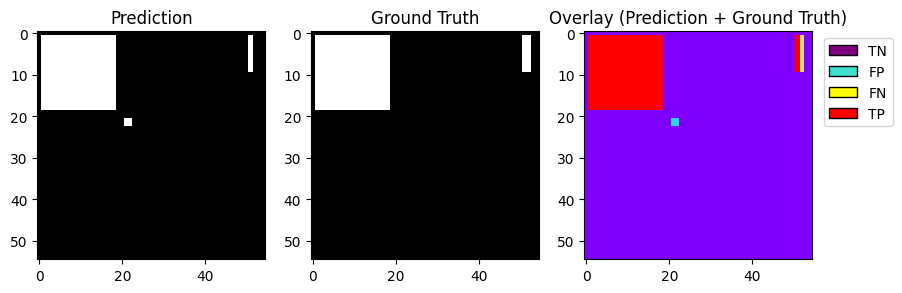

Legacy Dice           : 0.39199529134785166
Accounting for Lone FP: 0.828424153166421
Normal with accounting: 0.5522827687776141
Miccai Dice           : 0.5555555555555555
Proposed Dice         : 0.5555555555555555


In [3]:
pred = np.zeros((55, 55))
gt   = np.zeros((55, 55))

pred[1:19, 1:19] = 1
gt[1:19, 1:19] = 1

pred[21:23, 21:23] = 1

pred[1:10, 51:52] = 1
gt[1:10, 51:53] = 1

gt_display = gt*2

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(pred, cmap='gray')
ax[0].set_title('Prediction')

ax[1].imshow(gt_display, cmap='gray')
ax[1].set_title('Ground Truth')

im2 = ax[2].imshow(pred + gt_display, cmap='rainbow')
ax[2].set_title('Overlay (Prediction + Ground Truth)')

legend_elements = [Patch(facecolor='purple', edgecolor='black', label='TN'),
                   Patch(facecolor='turquoise', edgecolor='black', label='FP'),
                   Patch(facecolor='yellow', edgecolor='black', label='FN'),
                   Patch(facecolor='red', edgecolor='black', label='TP')]

# ax[2].legend(handles=legend_elements, loc='upper left')
ax[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.show()

before = dice(pred, gt)
pred[21:53, 21:53] = 0
after = dice(pred, gt)
reduction = (after - before) / after

pred[21:53, 21:53] = 1
withfp, withoutfp = proposed_metric(pred, gt)
_, miccai_score  = get_LesionWiseResults(pred, gt, 'BraTS-MET')

print('Legacy Dice           :', dice(pred, gt))
print('Accounting for Lone FP:', (withoutfp - (reduction*withoutfp)))
print('Normal with accounting:', (withfp - (reduction*withfp)))
print('Miccai Dice           :', miccai_score)
print('Proposed Dice         :', withfp)

In [4]:
#if the fp is the largest component? otherwise normal?